In [100]:
from pygalfitm.VOs import splus

from pygalfitm import PyGalfitm
import splusdata

conn = splusdata.connect("gustavo", "asdflkjh")

You have access to internal data


In [2]:
pygalgitm_object = splus.get_splus("test", 51.30076502619376, -32.90247622337992, 200, 'data/', 'outputs/', conn, bands=["z", "i", "r", "g", "u"])

File data/test_z.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
File data/test_i.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
File data/test_r.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
File data/test_g.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
File data/test_u.fits.fz already exists. If you mean to replace it then use the argument "overwrite=True".
finished
finished
finished
finished
finished


In [3]:
pygalgitm_object.activate_components(["sersic"])

In [4]:
pygalgitm_object.write_component("sersic", feedme_path="outputs/galfit.feedme")

In [5]:
pygalgitm_object.feedme_path

'outputs/galfit.feedme'

In [6]:
_ = pygalgitm_object.run()

In [7]:
print(_)


GALFITM Version galfitm-1.4.4
(based on GALFIT Version 3.0.5)


#  Input menu file: outputs/galfit.feedme

# IMAGE and GALFIT CONTROL PARAMETERS
A) data/test_z.fits,data/test_i.fits,data/test_r.fits,data/test_g.fits,data/test_u.fits      # Input data image (FITS file)
A1) z,i,r,g,u          # Band labels
A2) 8936.64,7670.59,6251.83,4758.49,3533.29     # Band wavelengths
B) outputs/testss.fits      # Output data image block
C) none,none,none,none,none 0.000   # Sigma image and min. sigma factor (made from data if blank or "none") 
D) data/psf_test_z.fits,data/psf_test_i.fits,data/psf_test_r.fits,data/psf_test_g.fits,data/psf_test_u.fits #        # Input PSF image and (optional) diffusion kernel
E) 1                   # PSF fine sampling factor relative to data 
F) none,none,none,none,none      # Bad pixel mask (FITS image or ASCII coord list)
G) none                # File with parameter constraints (ASCII file) 
H) 1    200  1    200  # Image region to fit (xmin xmax ymin ymax)
I) 200 

In [8]:
from astropy.io import fits

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.visualization import make_lupton_rgb

In [10]:
f = fits.open("outputs/testss.fits")

In [108]:
def read_output_to_class(filename):
    out = open(filename, "r").read()

    base = {}
    components = {}


    in_base = True
    in_current_component = ""

    current_component = ""
    
    for line in out.split("\n"):
        line.lstrip().split(" ")[0].replace(")", "")
        
        letter = line.lstrip().split(" ")[0].replace(")", "")
        
        if letter == "" or letter == "#" or len(letter) > 3:
            continue
            
        if letter == "0":
            [_, line_rest] = line.lstrip().split(" ", 1)
            [current_component, line_rest] = line_rest.split(" ", 1)
            
            if current_component in components:
                counter = 0
                for comp in components:
                    if current_component in comp:
                        counter += 1

                if counter != 0:
                    in_current_component = current_component + str(counter)
            else:
                in_current_component = current_component

            components[in_current_component] = {}
            in_base = False

        
        if in_base:
            base[letter] = {}

            [_, line_rest] = line.lstrip().split(" ", 1)
            [value, line_rest] = line_rest.lstrip().split("#", 1)
            comment = line_rest.lstrip().strip().strip("#")

            base[letter]['value'] = value
            base[letter]['comment'] = comment

        else:
            if letter == "0":
                continue
            [_, line_rest] = line.lstrip().split(" ", 1)
            [col1, line_rest] = line_rest.lstrip().split(" ", 1)
            [col2, line_rest] = line_rest.lstrip().split(" ", 1)
            [col3, line_rest] = line_rest.lstrip().split(" ", 1)
            comment = line_rest.lstrip().strip().strip("#")[1:]

            components[in_current_component][letter] = {}

            components[in_current_component][letter]["col1"] = col1
            components[in_current_component][letter]["col2"] = col2
            components[in_current_component][letter]["col3"] = col3
            components[in_current_component][letter]["comment"] = comment

        pyg = PyGalfitm()
        pyg.base = base
        pyg.components_config = components

    return pyg

In [41]:
c = read_output_to_class("outputs/testss.galfit.01.band")

 0) sersic                 #  Component type


In [127]:
pygalfit = read_output_to_class("outputs/testss.galfit.02.band")

filters = pygalfit.base['A1']['value'].split(",") 
for key, band in enumerate(filters): 
    filters[key] = band.strip()

In [131]:
component_selected = "sersic"
plot_parameters = [2, 3, 4]

plot_data = {}
for key, param in enumerate(plot_parameters):
    plot_data[band] = []
    values = pygalfit.components_config[component_selected][str(param)]["col1"].split(",")
    comment = pygalfit.components_config[component_selected][str(param)]["comment"]
    
    if comment.strip() == "":
        print("Please insert labels manually")

    for band in filters:
        plot_data[band].append( (values[key] ))

KeyError: 'z'

In [130]:
plot_data

{'z': '48.012', 'i': '48.012', 'r': '48.012', 'g': '48.012', 'u': '48.012'}

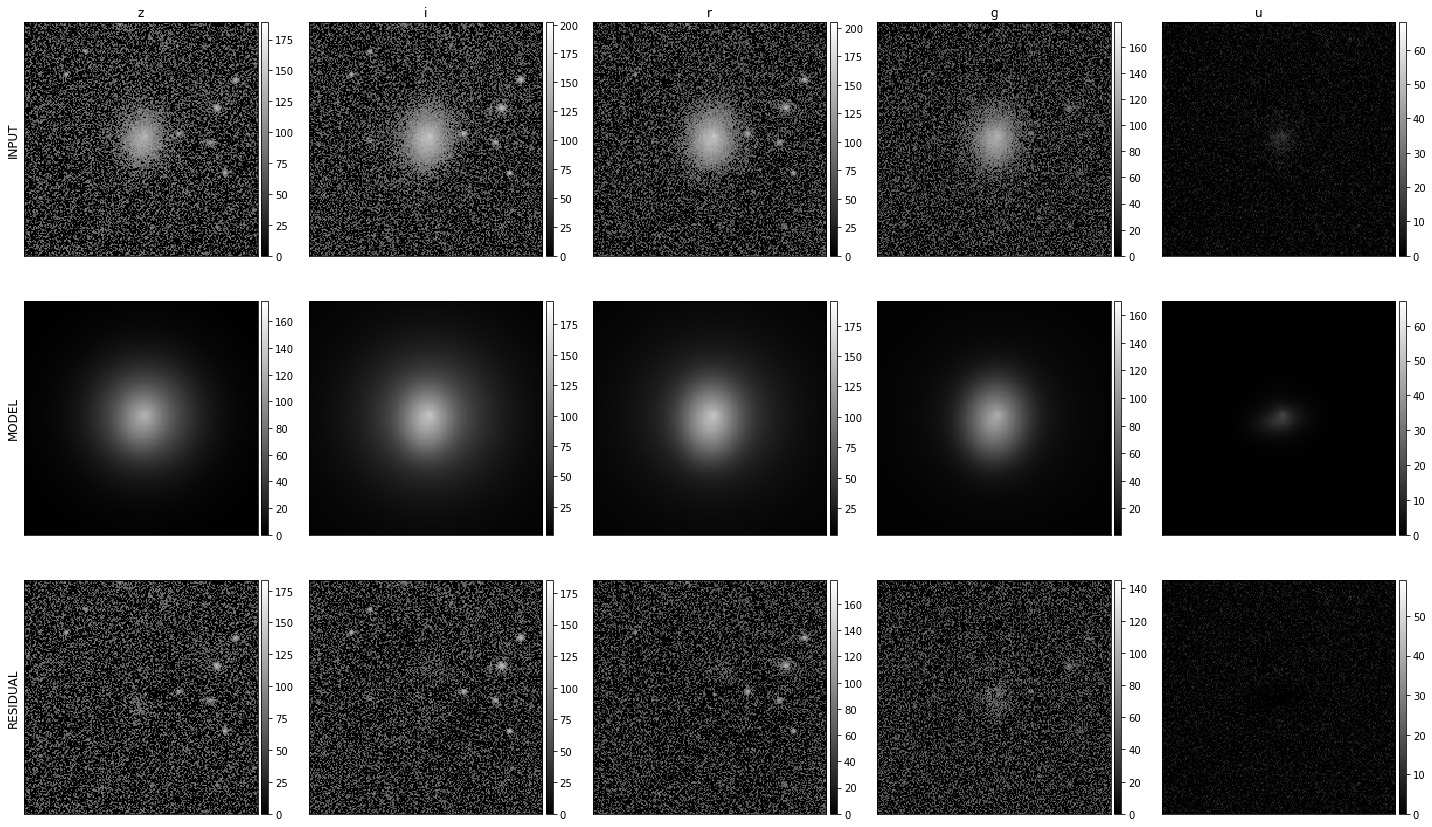

In [116]:



n_filters = len(filters)
filters_index = 0

fig = plt.figure(figsize=(n_filters * 4, 12))

y_label = ["INPUT", "MODEL", "RESIDUAL"]
y_label_index = 0

for i in range(1, bands * 3 + 1):
    ax = fig.add_subplot(3,5, i)
    im_data = make_lupton_rgb(f[i].data, f[i].data, f[i].data, stretch=0.2, Q=8)
    im = ax.imshow(im_data, cmap='gray', interpolation='None')
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if i % n_filters == 1:
        ax.set_ylabel(y_label[y_label_index], rotation=90, size='large')
        y_label_index += 1
    if i <= n_filters:
        ax.set_title(filters[filters_index])
        filters_index += 1
        
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')



fig.tight_layout()
plt.show()

In [50]:
file = fits.open("outputs/testss.fits")

In [51]:
file

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2807bd430>, <astropy.io.fits.hdu.image.ImageHDU object at 0x176433fa0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1764bb100>, <astropy.io.fits.hdu.image.ImageHDU object at 0x175519c40>, <astropy.io.fits.hdu.image.ImageHDU object at 0x281026070>, <astropy.io.fits.hdu.image.ImageHDU object at 0x281079790>, <astropy.io.fits.hdu.image.ImageHDU object at 0x281079af0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x281079dc0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1755147f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x281079850>, <astropy.io.fits.hdu.image.ImageHDU object at 0x28106e940>, <astropy.io.fits.hdu.image.ImageHDU object at 0x28106e8b0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x28106eb80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x28106e280>, <astropy.io.fits.hdu.image.ImageHDU object at 0x17651f5b0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x17651e3a0>, <astropy.io.fits.hdu.table.BinTableHD

In [53]:
file[6].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  200 / Length of data axis 1                          
NAXIS2  =                  200 / Length of data axis 2                          
PCOUNT  =                    0 / number of random group parameters              
GCOUNT  =                    1 / number of random groups                        
EQUINOX =        2000.00000000 / Mean equinox                                   
MJD-OBS =   5.878500000000E+04 / Modified Julian date at start                  
RADESYS = 'ICRS    '           / Astrometric system                             
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              
CUNIT1  = 'deg     '           / Axis unit                                      
CRVAL1  =   5.165919291670E+

In [199]:
pyg = PyGalfitm()

In [201]:
import splusdata

In [202]:
conn = splusdata.connect("gustavo", "asdflkjh")

You have access to internal data


In [203]:
f = conn.get_cut(0.1, 0.1, 200, "R")

In [213]:
import pygalfitm

In [230]:
import os
import sys
import copy

import requests

import pygalfitm

class PyGalfitm:
    """PyGalfitM wrapper class. 
    """    
    def __init__(self, executable = os.path.join(pygalfitm.__path__[0], "galfitm")):
        """Here we initialize the class with default values for the base and components. 

        Base values are in self.base variable 

        Components are stored in self.components_config
        """        
        self.feedme_path = "galfit.feedme"
        self.executable = executable

        self.base = {
            "A": {"value": "", "comment": "Input data image (FITS file)"},
            "A1": {"value": "g, r, i", "comment": "Nick names (band labels) "},
            "A2": {"value": "4770, 6231, 7625", "comment": "Effective wavelenghts"}, 
            "B": {"value": "4770, 6231, 7625", "comment": "Output data image block"}, 
            "C": {"value": "", "comment": "Sigma image name (made from data if blank or 'none')"},
            "D": {"value": "", "comment": "Input PSF image and (optional) diffusion kernel"}, 
            "E": {"value": "1", "comment": "PSF fine sampling factor relative to data "}, 
            "F": {"value": "none", "comment": "Bad pixel mask (FITS image or ASCII coord list)"}, 
            "G": {"value": "none", "comment": "File with parameter constraints (ASCII file) "},
            "H": {"value": "1    200  1  200", "comment": "Image region to fit (xmin xmax ymin ymax)"},
            "I": {"value": "200  200", "comment": "Size of the convolution box (x y)"},
            "J": {"value": "0,0,0", "comment": "Magnitude photometric zeropoint"},
            "K": {"value": "0.55  0.55", "comment": "Plate scale (dx dy)   [arcsec per pixel]"},
            "O": {"value": "regular", "comment": "Display type (regular, curses, both)"}, 
            "P": {"value": "0", "comment": "Choose: 0=optimize, 1=model, 2=imgblock, 3=subcomps"}, 
            "U": {"value": "0", "comment": ""}
        }

        self.components_config = {
            "sky" : {
                "1": {"col1": "BKGG,BKGR,BKGI", "col2": "0", "col3": "band", "comment": "Sky background at center of fitting region [ADUs]"},
                "2": {"col1": "0,0,0", "col2": "0", "col3": "band", "comment": "dsky/dx (sky gradient in x) [ADUs/pix]"},
                "3": {"col1": "0,0,0", "col2": "0", "col3": "band", "comment": "dsky/dy (sky gradient in y) [ADUs/pix]"},
                "Z": {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "sersic" : {
                "1":  {"col1": "200.0,200.0,200.0", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "200.0,200.0,200.0", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "Integrated magnitude"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "R_e (effective radius) [pix]"},
                "5":  {"col1": "4", "col2": "2", "col3": "band", "comment": "Sersic index n (de Vaucouleurs n=4)"},
                "9":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "expdisk" : {
                "1":  {"col1": "300", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "Integrated magnitude"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "R_s (disk scale lengths) [pix]"},
                "9":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "moffat" : {
                "1":  {"col1": "300", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "Total magnitude"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "FWHM"},
                "5":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "powerlaw"},
                "9":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "ferrer" : {
                "1":  {"col1": "300", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "Central surface brghtness [mag/arcsec^2]"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "Outer truncation radius  [pix]"},
                "5":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "Alpha (outer truncation sharpness) "},
                "6":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "Beta (central slope)"},
                "9":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "psf" : {
                "1": {"col1": "0,0,0", "col2": "0", "col3": "band", "comment": "position x [pixel]"},
                "2": {"col1": "0,0,0", "col2": "0", "col3": "band", "comment": "position y [pixel]"},
                "3": {"col1": "0,0,0", "col2": "0", "col3": "band", "comment": "total magnitude "},
                "Z": {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "nuker" : {
                "1":  {"col1": "300.", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "mu(Rb)            [surface brightness mag. at Rb]"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "Rb               [pixels]"},
                "5":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "alpha  (sharpness of transition)"},
                "6":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "beta   (outer powerlaw slope)"},
                "7":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "gamma  (inner powerlaw slope)"},
                "9": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "corser" : {
                "1":  {"col1": "300.", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "mu(Rb)            [surface brightness mag. at Rb]"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "Rb               [pixels]"},
                "5":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "alpha  (sharpness of transition)"},
                "6":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "gamma  (inner powerlaw slope)"},
                "7": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "R_e (half-light radius)   [pix]"},
                "8": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Sersic index n (de Vaucouleurs n=4) "},
                "9": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "devauc" : {
                "1":  {"col1": "300.", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "Total magnitude"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "Rs               [Pixels]"},
                "9":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "edgedisk" : {
                "1":  {"col1": "300.", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "central surface brightness  [mag/arcsec^2]"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "disk scale-height    [Pixels]"},
                "5":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "disk scale-length    [Pixels]"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "gaussian" : {
                "1":  {"col1": "300.", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "Total magnitude"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "FWHM               [pixels]"},
                "9":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            },
            "king" : {
                "1":  {"col1": "300", "col2": "1", "col3": "band", "comment": "Position x [pixel]"},
                "2":  {"col1": "357.4", "col2": "1", "col3": "band", "comment": "Position y [pixel]"},
                "3":  {"col1": "0,0,0", "col2": "3", "col3": "band", "comment": "mu(0)"},
                "4":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "Rc"},
                "5":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "Rt"},
                "6":  {"col1": "0,0,0", "col2": "2", "col3": "band", "comment": "alpha"},
                "9":  {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Axis ratio (b/a)"},
                "10": {"col1": "0,0,0", "col2": "1", "col3": "band", "comment": "Position angle (PA) [deg: Up=0, Left=90]"},
                "Z":  {"col1": "0", "col2": "", "col3": "", "comment": "Skip this model in output image? (yes=1, no=0)"}
            }
        }

        self.components = [
            "sersic",
            "expdisk", 
            "moffat",
            "ferrer",
            "psf",
            "sky"
        ]

        self.active_components = []

    def check_executable(self):
        if not os.path.exists(self.executable):
            print("Executable path not found. ")
            while True:
                i = input("Do you want to download the executable? (y/n): ")
                if i == "y":
                    break 
                elif i == "n":
                    return
            
            if sys.platform == "darwin":
                print("Downloading galfitm executable from " + "https://www.nottingham.ac.uk/astronomy/megamorph/exec/galfitm-1.4.4-osx")
                r = requests.get("https://www.nottingham.ac.uk/astronomy/megamorph/exec/galfitm-1.4.4-osx")
                open(os.path.join(pygalfitm.__path__[0], "galfitm"), "wb").write(r.content)
            
            if sys.platform == "linux":
                print("Downloading galfitm executable from " + "https://www.nottingham.ac.uk/astronomy/megamorph/exec/galfitm-1.4.4-linux-x86_64")
                r = requests.get("https://www.nottingham.ac.uk/astronomy/megamorph/exec/galfitm-1.4.4-linux-x86_64")
                open(os.path.join(pygalfitm.__path__[0], "galfitm"), "wb").write(r.content)
                
            print(f"""PLEASE RUN:
                chmod +x {os.path.join(pygalfitm.__path__[0], "galfitm")}
            """)

            raise Exception(f"Run chmod +x {os.path.join(pygalfitm.__path__[0], 'galfitm')}")

    def activate_components(self, component_s : list = None):
        """This function is used to activate one or more components. 
        You may pass just a string with the component name, or a list. 

        If left in blank, the active components are reseted. 
        Args:
            component_s (list or str, optional): Component name or list. Defaults to None.

        Raises:
            Exception: Not valid component
        """        
        if component_s is None:
            self.active_components = []
            return

        if isinstance(component_s, list):
            for comp in component_s:
                if comp in self.components:
                    count = 0 
                    for i in self.active_components:
                        if comp in i:
                            count += 1

                    if count == 0:
                        self.active_components.append(comp)
                    else:
                        self.active_components.append(str(comp) + str(count))
                        self.components_config[str(comp) + str(count)] = copy.deepcopy(self.components_config[str(comp)])
                        print("Added component as " + str(comp) + str(count))
                else:
                    raise Exception(f"Not valid component - {comp}")
        else:
            raise Exception(f"Parameter should be a list.")


    def set_base(self, item, value=""):
        """Function used to alter base values. 
        It's possible to pass only one value by giving the item and value to alter, or a dict with all keys and respective values.

        Ex:
            p.set_base("A1", "X")
            p.set_base("B", "Y")

            p.set_base({
                "A1": X
                "B": Y
                "C": Z
            })

        Args:
            item (str or dict): str of item name, or dict with infos.
            value (str, optional): value referred to item name. Defaults to "".

        Raises:
            KeyError: Parameter not valid
        """        
        if isinstance(item, dict):
            for i in item:
                self.base[i]["value"] = str(item[i])
        else:
            if item in self.base:
                self.base[item]["value"] = str(value)
            else:
                raise KeyError("Parameter not found in galfitm feedme base config.")
        
    def set_component(self, component, item, value = None, column = 1):
        """Function used to alter component values
        It's possible to pass only one value by giving the item and value to alter, or a dict with all keys and respective values.

        Ex:
            p.set_component("sersic", "1", "X", column=1)
            p.set_component("sersic", "1", "band", column=3)

            p.set_component("sersic", "2", "Y")
            
                OR

            p.set_component("sersic", {
                "A1": X
                "B": Y
                "C": Z
            })

                OR
            
            p.set_component("sersic", {
                "A1": (X, 1, band)
                "B": (Y, 1, band)
                "C": Z
            })

        Args:
            component (str): component name
            item (str or dict): item to change or dict with all infos. 
            value (str): Value referred in item (just used in case item is str).
            column (int, optional): Select column of change, 1, 2 or 3. Defaults to 1.

        Raises:
            Exception: Component not found.
        """        
        if column in [1, 2, 3]:
            column = 'col' + str(column)
        else:
            raise Exception("Column not valid.")
        if component in self.components_config:
            if isinstance(item, dict):
                for i in item:
                    if isinstance(item[i], tuple):
                        if len(item[i]) > 3:
                            raise Exception("Tuple not valid " + str(item[i]))
                        for key, val in enumerate(item[i]):
                            self.components_config[component][i]["col" + str(key + 1)] = str(val)
                    else:
                        self.components_config[component][i][column] = str(item[i])
            else:
                if item in self.components_config[component]:
                    self.components_config[component][item][column] = str(value)
        else:
            raise KeyError("Component not found.")


    def write_feedme(self, feedme_path = None):
        """Writes final feedme

        Args:
            feedme_path (str, optional): file path, if none select default file path. Defaults to None.
        """        
        if feedme_path is None:
            feedme_path = self.feedme_path
        else:
            self.feedme_path = feedme_path

        self.write_base(feedme_path)

        for component in self.active_components:
            self.write_component(component, feedme_path)
    
    def print_component(self, component):
        """Prints selected component to visualize informations

        Args:
            component (str): component name

        Raises:
            KeyError: Component not found.
        """        
        config = self.components_config[component]
        if component in self.components_config:
            for i in self.components_config[component]:
                final = i + ") " + config[i]['col1'].ljust(35) + " " + config[i]['col2'].ljust(5) + config[i]['col3'].ljust(10) + " # " + config[i]['comment']
                print(final)
        else:
            raise KeyError("Component not found.")
    
    def print_base(self):
        """Prints base params to visualize informations
        """        
        for param in self.base:
            final = str(param) + ") " + str(self.base[param]["value"]).ljust(32) + " # " + str(self.base[param]["comment"])
            print(final)


    def write_base(self, feedme_path = None):
        if feedme_path is None:
            feedme_path = self.feedme_path
        file = open(feedme_path, "w")
        for param in self.base:
            final = str(param) + ") " + str(self.base[param]["value"]).ljust(32) + " # " + str(self.base[param]["comment"]) + "\n"
            file.write(final)
        file.close()
    
    def write_component(self, component_name, feedme_path = None):
        if feedme_path is None:
            feedme_path = self.feedme_path

        if component_name in self.active_components:
            config = self.components_config[component_name]
            f = open(feedme_path, "a")
            f.write("\n\n\n")

            f.write("0) " + component_name.translate({ord(ch): None for ch in '0123456789'}) + "\n")
            for i in self.components_config[component_name]:
                final = i + ") " + config[i]['col1'].ljust(35) + " " + config[i]['col2'].ljust(5) + config[i]['col3'].ljust(10) + " # " + config[i]['comment'] + "\n"
                f.write(final)

            f.close()
    
    def check_number_of_filters(self):
        """Check parameter by parameter from active components that have correct number of bands. 
        """        
        nbands = len(self.base["A1"]["value"].split(","))
        correct = True

        for component in self.active_components:
            for att in self.components_config[component]:
                length = len(self.components_config[component][att]["col1"].split(","))
                if length > 1 and length != nbands:
                    print("Number of parameters incorrect in component: " + component + " - (" + att + ")")
                    correct = False
        return correct


    def run(self):
        """Run galfitm

        Returns:
            str: output of run.
        """        
        import subprocess

        if not self.check_number_of_filters():
            print("Warning! Running with possibly wrong parameters on components.")

        self.check_executable()
        output = subprocess.check_output(f'{self.executable} {self.feedme_path}', shell=True).decode("UTF-8")
        
        return output

In [231]:
pyg = PyGalfitm()

In [232]:
pyg.activate_components(["sersic", "psf"])

In [233]:
pyg.write_feedme("tei")